# Triangulação de Delaunay

Implemente um algoritmo para construir uma triangulação de Delaunay, considerando um
conjunto de pontos em posições arbitrárias (isto á, sem degenerações).
Seu programa de teste deve mostrar visualmente as triangulações geradas ou salvar em
arquivos texto a incidência de cada triângulo da triangulação de Delaunay (vi vj vk, índices dos
vértices).

In [213]:
import random
import time
from dataclasses import dataclass, field
from typing import List, Optional, Set, Tuple

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import patches


In [214]:
@dataclass
class Triangle:
    """Representa um triângulo na triangulação"""
    v0: int  # índice do vértice 0
    v1: int  # índice do vértice 1
    v2: int  # índice do vértice 2
    neighbors: List[Optional['Triangle']] = field(default_factory=lambda: [None, None, None])
    
    def __hash__(self):
        return hash((self.v0, self.v1, self.v2))
    
    def __eq__(self, other):
        if not isinstance(other, Triangle):
            return False
        return (self.v0, self.v1, self.v2) == (other.v0, other.v1, other.v2)
    
    def get_vertices(self):
        return [self.v0, self.v1, self.v2]
    
    def has_vertex(self, v):
        return v in [self.v0, self.v1, self.v2]

In [215]:

class DelaunayTriangulation:
    def __init__(self):
        self.points = []
        self.triangles = []
        
    def add_points(self, points):
        """Adiciona pontos para triangulação"""
        self.points = list(points)
        
    def _create_super_triangle(self):
        """Cria um super triângulo que engloba todos os pontos"""
        points_np = np.array(self.points)
        
        # Encontra os limites dos pontos
        min_x = np.min(points_np[:, 0])
        max_x = np.max(points_np[:, 0])
        min_y = np.min(points_np[:, 1])
        max_y = np.max(points_np[:, 1])
        
        # Centro e dimensões
        cx = (min_x + max_x) / 2
        cy = (min_y + max_y) / 2
        M = max(max_x - min_x, max_y - min_y) * 10
        
        # Vértices do super triângulo (como nos slides)
        p0 = [cx - 3*M, cy - 3*M]
        p1 = [cx + 3*M, cy - 3*M]
        p2 = [cx, cy + 3*M]
        
        # Adiciona os pontos do super triângulo no início
        self.super_triangle_indices = [0, 1, 2]
        self.points = [p0, p1, p2] + self.points
        
        # Cria o triângulo inicial
        return Triangle(0, 1, 2)
    
    def _point_in_circumcircle(self, p, tri):
        """Verifica se um ponto está dentro do círculo circunscrito do triângulo"""
        p0 = np.array(self.points[tri.v0])
        p1 = np.array(self.points[tri.v1])
        p2 = np.array(self.points[tri.v2])
        point = np.array(p)
        
        # Matriz para o teste do círculo circunscrito
        ax, ay = p0[0] - point[0], p0[1] - point[1]
        bx, by = p1[0] - point[0], p1[1] - point[1]
        cx, cy = p2[0] - point[0], p2[1] - point[1]
        
        # Determinante para o teste InCircle
        det = (ax*ax + ay*ay) * (bx*cy - by*cx) - \
              (bx*bx + by*by) * (ax*cy - ay*cx) + \
              (cx*cx + cy*cy) * (ax*by - ay*bx)
        
        return det > 0
    
    def _point_in_triangle(self, p, tri):
        """Verifica se um ponto está dentro de um triângulo usando coordenadas baricêntricas"""
        p0 = np.array(self.points[tri.v0])
        p1 = np.array(self.points[tri.v1])
        p2 = np.array(self.points[tri.v2])
        point = np.array(p)
        
        # Coordenadas baricêntricas
        v0 = p2 - p0
        v1 = p1 - p0
        v2 = point - p0
        
        dot00 = np.dot(v0, v0)
        dot01 = np.dot(v0, v1)
        dot02 = np.dot(v0, v2)
        dot11 = np.dot(v1, v1)
        dot12 = np.dot(v1, v2)
        
        inv_denom = 1 / (dot00 * dot11 - dot01 * dot01)
        u = (dot11 * dot02 - dot01 * dot12) * inv_denom
        v = (dot00 * dot12 - dot01 * dot02) * inv_denom
        
        # Verifica se o ponto está dentro
        return (u >= 0) and (v >= 0) and (u + v <= 1)
    
    def _find_triangle_containing_point(self, point_idx):
        """Encontra o triângulo que contém o ponto"""
        point = self.points[point_idx]
        
        for tri in self.triangles:
            if self._point_in_triangle(point, tri):
                return tri
        
        return None
    
    def _get_opposite_edge(self, tri1, tri2):
        """Encontra a aresta oposta compartilhada entre dois triângulos"""
        vertices1 = set([tri1.v0, tri1.v1, tri1.v2])
        vertices2 = set([tri2.v0, tri2.v1, tri2.v2])
        shared = vertices1 & vertices2
        
        if len(shared) != 2:
            return None
        
        shared_list = list(shared)
        return shared_list[0], shared_list[1]
    
    def _flip_edge(self, tri1, tri2):
        """Realiza o flip de uma aresta entre dois triângulos"""
        # Encontra os vértices compartilhados e opostos
        vertices1 = set([tri1.v0, tri1.v1, tri1.v2])
        vertices2 = set([tri2.v0, tri2.v1, tri2.v2])
        shared = list(vertices1 & vertices2)
        
        if len(shared) != 2:
            return False
        
        opposite1 = list(vertices1 - set(shared))[0]
        opposite2 = list(vertices2 - set(shared))[0]
        
        # Cria os novos triângulos após o flip
        new_tri1 = Triangle(opposite1, opposite2, shared[0])
        new_tri2 = Triangle(opposite1, opposite2, shared[1])
        
        # Remove os triângulos antigos
        self.triangles.remove(tri1)
        self.triangles.remove(tri2)
        
        # Adiciona os novos triângulos
        self.triangles.append(new_tri1)
        self.triangles.append(new_tri2)
        
        return True
    
    def _legalize_edge(self, point_idx, tri):
        """Verifica e corrige arestas ilegais após inserção de ponto"""
        # Encontra triângulos adjacentes
        adjacent_triangles = []
        
        for other_tri in self.triangles:
            if other_tri == tri:
                continue
                
            # Verifica se compartilha uma aresta
            shared_vertices = set([tri.v0, tri.v1, tri.v2]) & set([other_tri.v0, other_tri.v1, other_tri.v2])
            if len(shared_vertices) == 2:
                adjacent_triangles.append(other_tri)
        
        # Verifica cada triângulo adjacente
        for adj_tri in adjacent_triangles:
            # Verifica se o ponto está no círculo circunscrito do triângulo adjacente
            if self._point_in_circumcircle(self.points[point_idx], adj_tri):
                # Aresta é ilegal, faz o flip
                self._flip_edge(tri, adj_tri)
                
                # Recursivamente legaliza as novas arestas
                for new_tri in self.triangles:
                    if new_tri.has_vertex(point_idx):
                        self._legalize_edge(point_idx, new_tri)
                break
    
    def triangulate(self):
        """Executa a triangulação de Delaunay usando algoritmo incremental"""
        if len(self.points) < 3:
            return
        
        # Cria o super triângulo
        super_triangle = self._create_super_triangle()
        self.triangles = [super_triangle]
        
        # Adiciona pontos um por um (ordem aleatória para melhor performance)
        point_indices = list(range(3, len(self.points)))
        random.shuffle(point_indices)
        
        for point_idx in point_indices:
            point = self.points[point_idx]
            
            # Encontra todos os triângulos cujo círculo circunscrito contém o ponto
            bad_triangles = []
            for tri in self.triangles:
                if self._point_in_circumcircle(point, tri):
                    bad_triangles.append(tri)
            
            # Encontra o polígono de borda (cavity)
            polygon = []
            for tri in bad_triangles:
                for edge in [(tri.v0, tri.v1), (tri.v1, tri.v2), (tri.v2, tri.v0)]:
                    # Verifica se a aresta é compartilhada com outro triângulo ruim
                    is_shared = False
                    for other_tri in bad_triangles:
                        if tri == other_tri:
                            continue
                        other_edges = [(other_tri.v0, other_tri.v1), 
                                     (other_tri.v1, other_tri.v2), 
                                     (other_tri.v2, other_tri.v0)]
                        if edge in other_edges or (edge[1], edge[0]) in other_edges:
                            is_shared = True
                            break
                    
                    if not is_shared:
                        polygon.append(edge)
            
            # Remove os triângulos ruins
            for tri in bad_triangles:
                self.triangles.remove(tri)
            
            # Cria novos triângulos conectando o ponto ao polígono
            for edge in polygon:
                new_tri = Triangle(edge[0], edge[1], point_idx)
                self.triangles.append(new_tri)
        
        # Remove triângulos que contêm vértices do super triângulo
        self.triangles = [tri for tri in self.triangles 
                         if not any(v in self.super_triangle_indices 
                                  for v in [tri.v0, tri.v1, tri.v2])]
        
        # Remove os pontos do super triângulo
        self.points = self.points[3:]
        
        # Ajusta os índices dos triângulos
        for tri in self.triangles:
            tri.v0 -= 3
            tri.v1 -= 3
            tri.v2 -= 3
    
    def plot(self, show_circumcircles=False):
        """Visualiza a triangulação"""
        fig, ax = plt.subplots(figsize=(10, 10))
        
        # Plota os pontos
        points_np = np.array(self.points)
        ax.scatter(points_np[:, 0], points_np[:, 1], c='red', s=50, zorder=5)
        
        # Plota os triângulos
        for tri in self.triangles:
            vertices = np.array([self.points[tri.v0], 
                                self.points[tri.v1], 
                                self.points[tri.v2]])
            triangle = patches.Polygon(vertices, fill=False, edgecolor='blue', linewidth=1)
            ax.add_patch(triangle)
            
            if show_circumcircles:
                # Calcula e desenha o círculo circunscrito
                center, radius = self._circumcircle(tri)
                circle = plt.Circle(center, radius, fill=False, edgecolor='green', 
                                  linewidth=0.5, alpha=0.3)
                ax.add_patch(circle)
        
        ax.set_aspect('equal')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_title('Triangulação de Delaunay - Algoritmo Incremental')
        plt.grid(True, alpha=0.3)
        plt.show()
    
    def _circumcircle(self, tri):
        """Calcula o centro e raio do círculo circunscrito"""
        p0 = np.array(self.points[tri.v0])
        p1 = np.array(self.points[tri.v1])
        p2 = np.array(self.points[tri.v2])
        
        ax, ay = p0
        bx, by = p1
        cx, cy = p2
        
        d = 2 * (ax * (by - cy) + bx * (cy - ay) + cx * (ay - by))
        if abs(d) < 1e-10:
            return (0, 0), 0
        
        ux = ((ax*ax + ay*ay) * (by - cy) + 
              (bx*bx + by*by) * (cy - ay) + 
              (cx*cx + cy*cy) * (ay - by)) / d
        
        uy = ((ax*ax + ay*ay) * (cx - bx) + 
              (bx*bx + by*by) * (ax - cx) + 
              (cx*cx + cy*cy) * (bx - ax)) / d
        
        center = np.array([ux, uy])
        radius = np.linalg.norm(p0 - center)
        
        return center, radius

In [216]:
def orientacao(p1, p2, p3):
    """
    Calcula o produto vetorial (p2-p1) x (p3-p1)
    Retorna positivo se p1,p2,p3 estão em sentido anti-horário
    """
    return (p2[0] - p1[0]) * (p3[1] - p1[1]) - (p2[1] - p1[1]) * (p3[0] - p1[0])


def gerar_pontos_nao_colineares(
    n: int,
    min_val: float = 0,
    max_val: float = 10,
    min_area: float = 0.01,
    seed: int = None,
) -> np.ndarray:
    """
    Gera n pontos garantidamente não colineares

    Args:
        n: número de pontos
        min_val: valor mínimo das coordenadas
        max_val: valor máximo das coordenadas
        min_area: área mínima do triângulo formado por quaisquer 3 pontos
        seed: semente para reprodutibilidade
    """
    if seed is not None:
        np.random.seed(seed)

    if n < 3:
        return np.random.uniform(min_val, max_val, (n, 2))

    pontos = []
    max_tentativas = 1000

    # Adiciona os primeiros dois pontos
    pontos.append(np.random.uniform(min_val, max_val, 2))
    pontos.append(np.random.uniform(min_val, max_val, 2))

    # Adiciona pontos restantes garantindo não colinearidade
    while len(pontos) < n:
        tentativas = 0
        while tentativas < max_tentativas:
            novo_ponto = np.random.uniform(min_val, max_val, 2)

            # Verifica se o novo ponto não é colinear com nenhum par existente
            valido = True
            for i in range(len(pontos)):
                for j in range(i + 1, len(pontos)):
                    # Calcula a área do triângulo
                    area = abs(orientacao(pontos[i], pontos[j], novo_ponto) * 0.5)
                    if area < min_area:
                        valido = False
                        break
                if not valido:
                    break

            if valido:
                pontos.append(novo_ponto)
                break

            tentativas += 1

        if tentativas == max_tentativas:
            # Se não conseguir, ajusta ligeiramente um ponto aleatório
            novo_ponto = np.random.uniform(min_val, max_val, 2)
            novo_ponto += np.random.normal(0, 0.1, 2)
            pontos.append(novo_ponto)

    return np.array(pontos, dtype=np.float64)



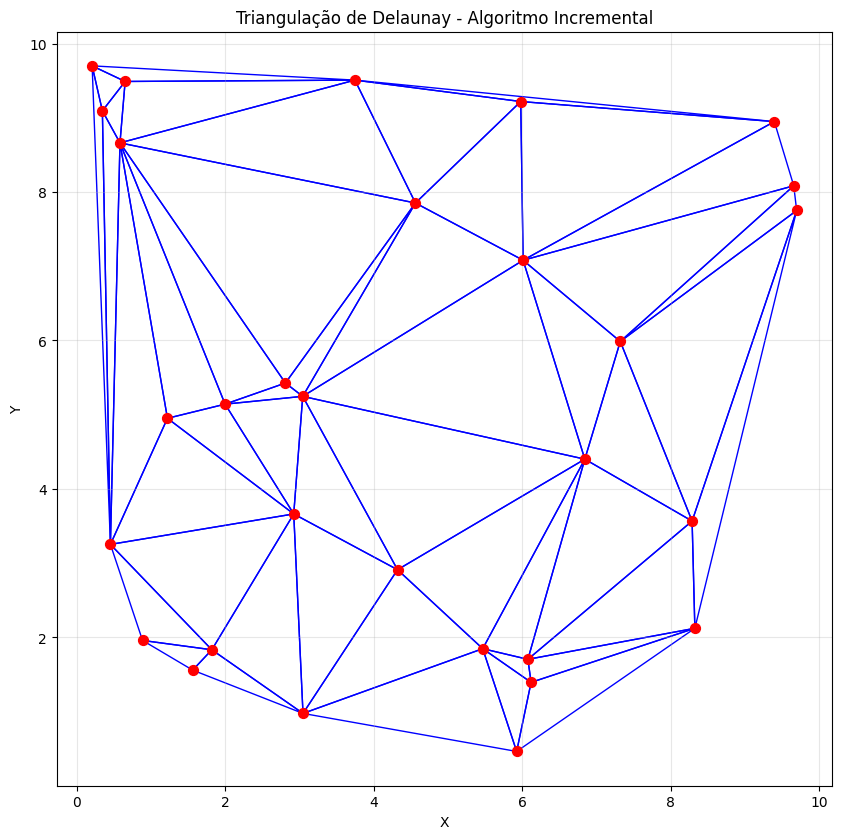

In [217]:
pontos = gerar_pontos_nao_colineares(30, seed=42)
triangulacao = DelaunayTriangulation()
triangulacao.add_points(pontos)
triangulacao.triangulate()
triangulacao.plot()

